# MySql Copilot Experiment Result Analysis

This notebook demonstrates how the evaluation result of LLM Agents can analyzed.

In [1]:
%pip install -q pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports
import os
import sys
import json
from ast import literal_eval
import pandas as pd
from sqlalchemy import create_engine
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.join(os.path.abspath(''), '../experimentation'))
sys.path.append(os.path.join(os.path.abspath(''), '../'))
from exp_src.persistence.database_setup import DataPersistence

In [3]:
engine = create_engine(DataPersistence().get_connection_url())

In [4]:
df_steps = pd.read_sql_table('steps', engine)
df_feedbacks = pd.read_sql_table('feedbacks', engine)

## Evaluation Result: LLM As Judge (Azure AI Foundry)

**Prerequisites:**

- Create Azure AI Foundry workspace and store the project connection string (`AIPROJECT_CONNECTION_STRING`) in the current directory [.env](.env) file.
- Deploy the LLM model GPT-4 or above is preferred. Store the model name (`EVALUATION_MODEL`) in the current directory [.env](.env) file.

In [8]:
# Extract data convert to JSONL format as per Azure Prompt Flow
df_eval_dataset = df_steps[["id", "name", "type", "metadata", "threadId", "parentId", "input", "output"]]
df_eval_dataset["experiment"] = df_eval_dataset["metadata"].apply(lambda x: literal_eval(x)["experiment"] if "experiment" in literal_eval(x) else None)
df_eval_dataset = df_eval_dataset[~df_eval_dataset["name"].isin(["on_chat_start", "user", "admin", "termination"])]
df_eval_dataset["input"] = df_eval_dataset.apply(lambda x: df_eval_dataset[(df_eval_dataset["name"] == "on_message") 
    & (df_eval_dataset["id"] == x["parentId"])]["input"].values[0] if x["name"] != "on_message" else x["input"], axis=1)
df_eval_dataset = df_eval_dataset[~df_eval_dataset["name"].isin(["on_message"])]
df_eval_dataset.drop(columns=["metadata", "type"], inplace=True)
df_eval_dataset["output"] = df_eval_dataset["output"].apply(lambda x: x+"\n" if x is not None else x)
df_eval_dataset["conversation_history"] = df_eval_dataset.groupby("threadId")["output"].transform(lambda x: x.shift().fillna("").cumsum())
df_eval_dataset = df_eval_dataset[~df_eval_dataset["name"].isin(["executor"])]

In [9]:
# Create individual JSONL files for each name
if os.path.exists(".evaluation_input_data"):
    for file in os.listdir(".evaluation_input_data"):
        os.remove(f".evaluation_input_data/{file}")
    os.rmdir(".evaluation_input_data")
os.makedirs(".evaluation_input_data")
for name in df_eval_dataset["name"].unique():
    df_name = df_eval_dataset[df_eval_dataset["name"] == name]
    df_name.to_json(f".evaluation_input_data/{name}.jsonl", orient="records", lines=True)

Run the following command from the same directory as the evaluation result file to generate the analysis.

```bash
pip install -r requirements_eval.txt
python ./run_azure_ai_foundry_local_eval.py error ./.evaluation_input_data/error.jsonl
python ./run_azure_ai_foundry_local_eval.py observe ./.evaluation_input_data/observe.jsonl
python ./run_azure_ai_foundry_local_eval.py select ./.evaluation_input_data/select.jsonl
python ./run_azure_ai_foundry_local_eval.py verify ./.evaluation_input_data/verify.jsonl
```

In [12]:
# Read the output metrics
df_llm_eval = pd.DataFrame()
for file in os.listdir(".evaluation_output_data"):
    json_content_str = open(f".evaluation_output_data/{file}", "r").read()
    json_content = json.loads(json_content_str)
    tmp_df = pd.DataFrame(json_content["rows"])
    df_llm_eval = pd.concat([df_llm_eval, tmp_df])
    del tmp_df
df_llm_eval = df_llm_eval[["inputs.name", "inputs.experiment", "outputs.groundedness.groundedness"]]
df_llm_eval.columns = ["name", "experiment", "groundedness_score"]
df_llm_eval["groundedness_score"] = df_llm_eval["groundedness_score"].apply(lambda x: (x-1)/4)
df_llm_eval = df_llm_eval.groupby(["experiment", "name"]).mean().reset_index()
df_llm_eval = df_llm_eval.pivot(index="experiment", columns="name", values="groundedness_score").reset_index()
df_llm_eval["overall_groundedness_score"] = df_llm_eval[[col for col in df_llm_eval.columns if col != "experiment"]].mean(axis=1)
df_llm_eval.head(20)

name,experiment,error,observe,select,verify,overall_groundedness_score
0,SQL Copilot Experiment,1.0,0.0,0.916667,0.954545,0.717803


## Evaluation Result: Human Evaluation

In [13]:
# Human evaluation result per experiment
df = pd.merge(df_steps, df_feedbacks, left_on='id', right_on='forId')
df = df.drop(columns=['id_y', 'forId', 'threadId_y'])
df = df.rename(columns={'id_x': 'id', 'threadId_x': 'threadId'})
df["experiment"] = df["metadata"].apply(lambda x: literal_eval(x)["experiment"] if "experiment" in literal_eval(x) else None)
df["experiment"] = df.apply(lambda x: x["experiment"] if x["experiment"] is not None else df.iloc[x.name + 1]["experiment"], axis=1)
df_agents_summary = df[["experiment", "name", "value"]].groupby(["experiment", "name"], sort=False).mean().reset_index()
df_agents_summary = df_agents_summary.pivot(index='experiment', columns='name', values='value').reset_index()
df_agents_summary = df_agents_summary.rename(columns={"on_message": "overall_score"})
cols = df_agents_summary.columns.tolist()
cols = [c for c in cols if c != "overall_score"]
cols.insert(1, "overall_score")
df_agents_summary = df_agents_summary[cols]
df_agents_summary.head(20)

name,experiment,overall_score,error,executor,observe,select,verify
0,SQL Copilot Experiment,0.4,1.0,0.380952,0.6,0.444444,0.272727


## Evaluation Result: LLM As Judge vs Human Evaluation

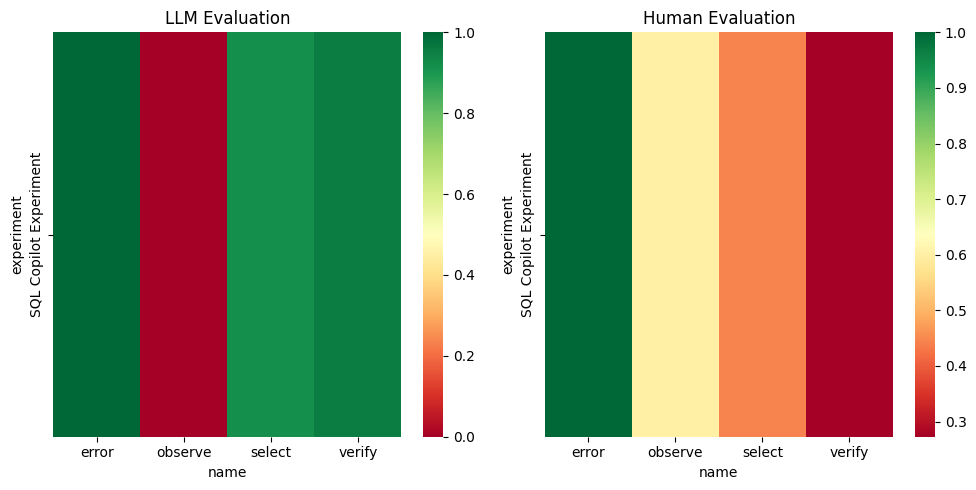

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(df_llm_eval.set_index('experiment').drop(columns='overall_groundedness_score'), cmap=sns.color_palette("RdYlGn", as_cmap=True), ax=ax[0])
sns.heatmap(df_agents_summary.set_index('experiment').drop(columns=['overall_score', 'executor']), cmap=sns.color_palette("RdYlGn", as_cmap=True), ax=ax[1])
ax[0].set_title('LLM Evaluation')
ax[1].set_title('Human Evaluation')
plt.tight_layout()
plt.show()

